## Peptide Identification Workflow and SILAC Analysis Demonstration

Here we demonstrate a Multiplierz SILAC workflow on a complex, multi-fraction
mixture by replicating the data analysis from

[<i>Wu X, Zahari MS, Renuse S, Nirujogi RS, Kim MS, Manda SS, Stearns
V, Gabrielson E, Sukumar S, Pandey A. Phosphoproteomic Analysis Identifies
Focal Adhesion Kinase 2 (FAK2) as a Potential Therapeutic Target for Tamoxifen
Resistance in Breast Cancer. Mol Cell Proteomics. 2015 Nov;14(11):2887-900</i>](https://www.ncbi.nlm.nih.gov/pubmed/26330541)

Here SILAC labelling was used to show upregulation of a Temoxifen-relevant
pathway mediated by a set of phosphorylation kinases.  The Wu et al performed
the original analysis with Proteome Discoverer, the proteomic analysis software
package distributed by Thermo Scientific for use with their machines; in
addition to the analysis, we show that Multiplierz obtains results in line
with the original data.

***
We start by importing the Multiplierz libraries we'll need, along with some other modules from the Python standard libraries.


In [4]:
import multiplierz

# Multiplierz interface to Mascot search submission/retrieval.
from multiplierz.mzSearch import MascotSearch

# Multiplierz utilities for post-search processing of results.
from multiplierz.post_process import combine_accessions, calculate_FDR
# The function for performing 2-plex SILAC analysis.
from multiplierz.mzTools.silacAnalysis import SILAC2Plex
# If we were analyzing a 3-plex sample, we would instead use 
#from multiplierz.mzTools.silacAnalysis import SILAC3Plex

# The extract() function pulls MS2 data out of an instrument data file
# into an MGF file.
from multiplierz.mgf import extract

# For the comparison step, we'll need to read PSM results; this can
# be done through mzReport.
from multiplierz.mzReport import reader

import os
from collections import defaultdict
from numpy import log

# Required for internal multiprocessing performed in Multiplierz to be
# compatible with iPython.
import sys
sys.modules['__main__'].__file__ = 'ipython'

# Suppressing progress reporting for this workbook.
multiplierz.verbose_mode = False

We will also need the paths to the raw MS data the script will be analyzing, and the Mascot parameter file that we use as the basis of the database search session.

In [21]:
data_files = ['RO-CS-140925_PandeyA_ZM-pST_Fraction-1.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-2.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-3.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-4.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-5.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-6.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-7.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-8.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-9.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-10.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-11.raw',
              'RO-CS-140925_PandeyA_ZM-pST_Fraction-12.raw']

par_file = 'phospho_SILAC.par'

***

###Peptide Identification Workflow

The first step is to extract MS2 spectra from the .RAW files into the MGF format understood by Mascot; the Multiplierz extract() function automates this process.

In [23]:
mgf_files = []
for data_file in data_files:
    mgf_file = extract(data_file,
                       centroid = True,
                       deisotope_and_reduce_charge = True,
                       precursor_tolerance = 0.01)
    mgf_files.append(mgf_file)

We use mzSearch to search each MGF file using our phospho_SILAC.par parameter set; however, we can customize the search process, in case the settings we have in the parameter file don't suit this particular context exactly.  Here we define handle_search() to run the customized search process.

In [24]:
def handle_search(mgf_file, par_file):
    searcher = MascotSearch(par_file)
    
    # Suppose we obtained this data from a different instrument
    # than we're used to; we can use the script itself to set
    # instrument-specific settings (such as mass accuracy, here)
    # for this particular workflow.
    searcher['TOL'] = 10
    searcher['TOLU'] = 'ppm'
    searcher['ITOL'] = 0.05
    searcher['ITOLU'] = 'Da'

    # We can also add a variable modification list appropriate for the sample.
    # The list should be the names listed in the Mascot mod list, with amino acids
    # they're expected to bind to, joined by commas.
    mod_list = ['Oxidation (M)',
                'Phospho (ST)',
                'Phospho (Y)']
    searcher['IT_MODS'] = ','.join(mod_list)
    # (Changing the fixed mod list can be done likewise, by altering the 'MODS' field.)

    # The QUANTITATION field indicates the kind of quantitation being
    # performed; the string values for each mode can be found on the Mascot
    # search submission form, or by using the mzDesktop Mascot interface
    # utility to create a custom .par file.
    searcher['QUANTITATION'] = 'SILAC K+8 R+10 [MD]'
    
    result_file = searcher.run_search(mgf_file,
                                      user = 'pipeline',
                                      password = 'pipeline')
    # .run_search() executes the search on our Mascot server.
    # The return value is a full file path to the result
    # file downloaded.
    
    # Before we do SILAC quantitation, we'll want to consolidate
    # protein IDs into one PSM per peptide (combine_accessions)
    # and ensure that we're examining confident, forward-sequence
    # peptide matches through the forward/reverse decoy
    # search method (calculate_FDR).
    result_file = combine_accessions(result_file, result_file)
    result_file = calculate_FDR(result_file, outputfile = result_file)
    # In general, there are two ways to know the path of a file written
    # by a multiplierz function; setting it in the output file argument
    # to the function, or by capturing the function's return value.  For
    # the sake of demonstration, here we do both, redundantly.
    
    return result_file

psm_reports = []
for mgf_file in mgf_files:
    psm_report = handle_search(mgf_file, par_file)
    psm_reports.append(psm_report)

If all we want is to run the peptide identification search, *we're done*!  `psm_reports` contains a list of file paths containing the PSMs found in each data file.
***

###SILAC Analysis

Now that we have PSM reports, we can run the SILAC analysis function to obtain ratio values for the peptides we've obtained.  This is a single-step process!  The SILAC function can accept a set of files from a multi-fraction experiment, and outputs a combined output report accross all files (which retains information about which peptide came from what fraction, additionally.)

In [25]:
silac_annotated_file = SILAC2Plex(datafiles = data_files, 
                                  resultfiles = psm_reports,
                                  heavyTags = {'K':'Label:13C(6)15N(2)', 
                                               'R':'Label:13C(6)15N(4)'})

`silac_annotated_file` now contains the path to the combined report file, in Excel format.
***

###Result Comparison

As a demonstration of the effectiveness of the Multiplierz analysis, we can compare it to the result obtained by the data's original authors via Proteome Discoverer.  We extracted a PSM report from the .MSF file available on the [paper's PRIDE repository](https://www.ebi.ac.uk/pride/archive/projects/PXD001812) into Excel format, which we can then read using mzReport.

In [26]:
wu_et_al_pd_report = r'RO-CS-140925_PandeyA_ZM-pST_Fraction-9.rank_one.xlsx'

proteome_discoverer_psms = list(reader(wu_et_al_pd_report))
multiplierz_psms = list(reader(silac_annotated_file))

We will be comparing the quantitation values found on a peptide-by-peptide basis; therefore, we need to define a way to indicate a particular peptide which is identical across formats.  Helpfully, Proteome Discoverer and Mascot have very similar output values for peptide sequence and variable modifications, but a small amount of conversion needs to be done (e.g., convert modification names from the Proteome Discoverer format ("S3(Phospho)") to Mascot format ("S3: Phospho").) 

In [27]:
def byPeptideMascot(psm):
    mods = frozenset([x.strip() for x in psm['Variable Modifications'].split(';') if x])
    
    return (psm['Peptide Sequence'],
            mods,
            psm['Charge'])

def byPeptidePD(psm):
    mods = [x.strip() for x in psm['Modifications'].split(';') if x]
    mods = [x for x in mods if 'Carbamidomethyl' not in x] # Fixed mods not reported by Mascot
    converted_mods = set()
    for mod in mods:
        i = mod.find('(')
        converted_mods.add('%s: %s' % (mod[:i], mod[i+1:-1]))
    
    return (psm['Annotated Sequence'].upper(),
            frozenset(converted_mods),
            psm['Charge'])    

Now we can use these peptide values to gather PSMs by peptide, and compile a list of peptides in common between files.

In [28]:
m_by_pep = defaultdict(list)
for psm in multiplierz_psms:
    m_by_pep[byPeptideMascot(psm)].append(psm)
pd_by_pep = defaultdict(list)
for psm in proteome_discoverer_psms:
    pd_by_pep[byPeptidePD(psm)].append(psm)

common_peptides = set(m_by_pep.keys()) & set(pd_by_pep.keys())

It is also worth making sure, at this point, that the results from the database search step were comparable between our analysis and the original:

In [29]:
print "Peptides found by Multiplierz workflow: %d" % len(m_by_pep)
print "Peptides found by Proteome Discoverer workflow; %d" % len(pd_by_pep)
print '-'
print "Peptides found by Multiplierz but missed by Proteome Discoverer: %d" % len(set(m_by_pep) - set(pd_by_pep))
print "Peptides found by Proteome Discoverer but missed by Multiplierz: %d" % len(set(pd_by_pep) - set(m_by_pep))
print '-'
print "Total peptides found in common: %d" % len(common_peptides)

Peptides found by Multiplierz workflow: 19782
Peptides found by Proteome Discoverer workflow; 20563
-
Peptides found by Multiplierz but missed by Proteome Discoverer: 2271
Peptides found by Proteome Discoverer but missed by Multiplierz: 3052
-
Total peptides found in common: 17511


Now we can collect the quantitation values for each peptide in the common list.  Not all peptides in this list will have been successfully quantified; we count only peptides that have been quantified by both workflows.

In [30]:
quant_values = []
loss_from_file_mismatch = 0
loss_from_no_PD_quant = 0
loss_from_no_Multiplierz_quant = 0
for pep in common_peptides:
    m_psms = m_by_pep[pep]
    pd_psms = pd_by_pep[pep]
    
    # Since many peptides will appear in multiple fractions, its important to
    # take compare the quant value from the fraction in which the peptide was
    # most apparent. For the sake of simplicity, we use a
    # number-of-acquisitions based method to determine this.
    m_source_files = [os.path.basename(x['Source'])[:-9] for x in m_psms]
    pd_source_files = [x['Spectrum File'] for x in pd_psms]
    possible_files = set(m_source_files) & set(pd_source_files)
    if not possible_files:
        loss_from_file_mismatch += 1
        continue
    best_file = max(possible_files, 
                    key = lambda x: m_source_files.count(x) + pd_source_files.count(x))
    m_psm = [x for x in m_psms if best_file in x['Source']][0]
    pd_psm = [x for x in pd_psms if best_file in x['Spectrum File']][0]
    
    try:
        pd_quant = float(pd_psm['Heavy'])/float(pd_psm['Light'])
    except ValueError:
        loss_from_no_PD_quant += 1
        continue
    m_quant = m_psm['Overlap Ratio (H/L)']
    if m_quant == '-':
        loss_from_no_Multiplierz_quant += 1
        continue
    m_quant = float(m_quant)
    quant_values.append((log(pd_quant), log(m_quant), pep))

print ("Lost due to file mismatch: %d\tLost due to no PD quantification: %d"
       "\tLost due to no Multiplierz quantification: %d" % (loss_from_file_mismatch, loss_from_no_PD_quant,
                                                           loss_from_no_Multiplierz_quant))
print "Total mutually quantified peptides: %d" % len(quant_values)

Lost due to file mismatch: 24	Lost due to no PD quantification: 1962	Lost due to no Multiplierz quantification: 1722
Total mutually quantified peptides: 13803


Now we can use Matplotlib to generate a plot comparing quantitation values for each peptide.

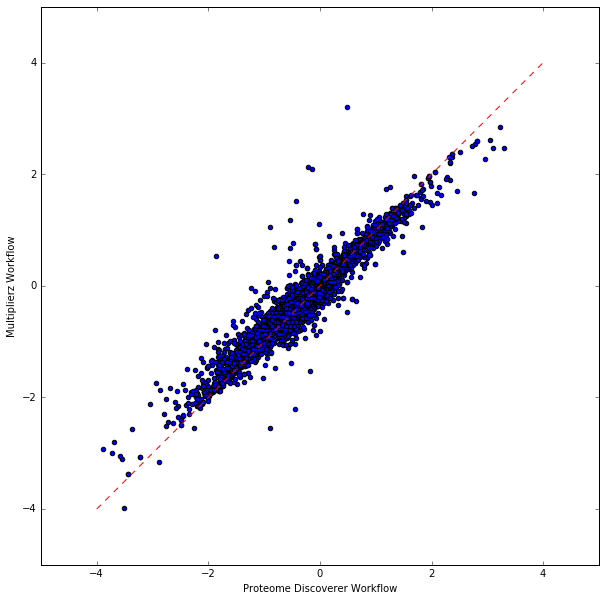

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
pd_quants, m_quants, _ = zip(*quant_values)
plt.figure(figsize = (10,10))
plt.scatter(pd_quants, m_quants)
plt.plot([-4, 4], [-4, 4], color = 'r', linestyle = '--') # 1-to-1 line.
plt.ylabel('Multiplierz Workflow')
plt.xlabel('Proteome Discoverer Workflow')
plt.show()

We can thereby see that, aside from a handful of outliers, the vast majority of the more than 13,000 peptides shown report essentially identical quantitation values in the Multiplierz results and the Proteome Discoverer results.